# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle
import numpy as np
from numpy import genfromtxt

# TODO: Fill this in based on where you saved the training and testing data

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Read signnames.csv
sign_names = genfromtxt('signnames.csv', delimiter=',', dtype=None, skip_header=1)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train) | set(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

/home/carnd/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Printing all the signs...


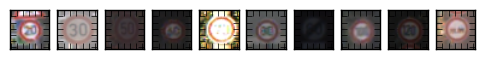

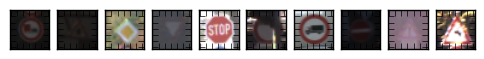

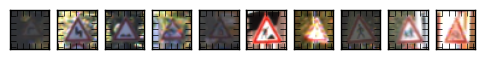

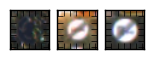

Printing histogram of the signs...


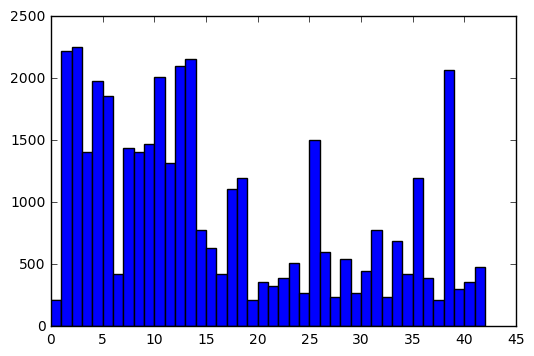

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

sign_image = [None] * n_classes
hist, bins = np.histogram(y_train, bins = range(n_classes))

i = 0
for y in y_train:
    # Get image index
    index = y_train[i]
    
    # Check if we have this image index already
    if (sign_image[index] == None):
        sign_image[index] = X_train[i]
        numberOfFoundImages = sum(x is not None for x in sign_image)

    if (numberOfFoundImages == n_classes):
        break
        
    i += 1
    
# Plot all the 43 signs
print("Printing all the signs...")
start = 0
rows = int(n_classes / 10) + 1

for row in range(rows):
    end = start + 10
    i = 1
    fig = plt.figure()
    for img in sign_image[start:end]:
        f = fig.add_subplot(1, 10, i)
        f.set_xticklabels([])
        f.set_yticklabels([])
        i += 1  
        plt.imshow(img)
      
    plt.show()
    start += 10


# Plot a histogram of the 43 signs
print("Printing histogram of the signs...")
plt.hist(y_train, bins=range(n_classes))
plt.show()

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
# Color space conversion and normalization routines

def normalize(arr, mean, std):
    return (arr - mean)/std

def weightedAverage(pixel):
    return 0.299*pixel[0] + 0.587*pixel[1] + 0.114*pixel[2]

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def _ycc(r, g, b): # in (0,255) range
    y = .299*r + .587*g + .114*b
    cb = 128 -.168736*r -.331364*g + .5*b
    cr = 128 +.5*r - .418688*g - .081312*b
    return y, cb, cr

def _rgb(y, cb, cr):
    r = y + 1.402 * (cr-128)
    g = y - .34414 * (cb-128) -  .71414 * (cr-128)
    b = y + 1.772 * (cb-128)
    return r, g, b

In [6]:
### Create a validation set
# Split the training set into a training and validation
msk = np.random.rand(len(X_train)) < 0.8

X_train_masked = X_train[msk]
y_train_masked = y_train[msk]
X_validation = X_train[~msk]
y_validation = y_train[~msk]
X_train = X_train_masked
y_train = y_train_masked

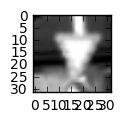

In [7]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle


# Convert to gray scale
# Convert to YUV space. Apply global (local?) normalization to the Y channel

# Build a jittered data set by adding 5 transformed versions of the original image

# 1. Convert to grayscale
X_train =  rgb2gray(X_train)
X_validation = rgb2gray(X_validation)
X_test = rgb2gray(X_test)

# Mean & std dev of the pixels in the training set
mean = np.mean(X_train)
std = np.std(X_train)

# 2. Normalize images (X_train & X_test)
X_train = normalize(X_train, mean, std)
X_validation = normalize(X_validation, mean, std)
X_test = normalize(X_test, mean, std)

# 3. Reshape to 32x32x1
X_train = X_train.reshape((X_train.shape[0], 32, 32, 1))
X_validation = X_validation.reshape((X_validation.shape[0], 32, 32, 1))
X_test = X_test.reshape((X_test.shape[0], 32, 32, 1))

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")

if (len(X_train[0].shape) > 2):
    l1_input_depth = X_train[0].shape[2]
else:
    l1_input_depth = 1

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I performed the following preprocessing steps:

1. I split the training data into training and validation set before performing preprocessing. I used 20% of the original training data for validation.
2. I converted the data (training, validation and test) into grayscale images.
3. I normalized the grayscale image by subtracting the mean and dividing by standard deviation. I used the training data only (not validation or test data) to calculate the mean and standard deviation of the images.

In [8]:
### Generate data additional data (OPTIONAL!)
### Feel free to use as many code cells as needed.
# Strategies for augmenting data. Which package to use?
# Random horizonal flip
# Random rotation
# Random blur

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**  

I setup the training and validation data before performing the preprocessing step. I randomly masked 20% of the original training data for use for validation.  
I did not generate any additional data - mainly because I could not figure out an appropriate library to use. I would have liked to augment the data by adding the following generated images:  
1. Random horizontal flip of the image  
2. Random rotation of the image  
3. Random blur

### Setup Tensorflow

In [9]:
import tensorflow as tf

EPOCHS = 1000
BATCH_SIZE = 64

### Architecture

In [10]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Start with LeNet architecture first
from tensorflow.contrib.layers import flatten

# XNet architecture
# References:
#             http://cs231n.github.io/neural-networks-2/
#             https://www.tensorflow.org/tutorials/mnist/pros/
# L1. Conv - Relu (input 32x32x1 output 28x28x32)
# Pool        (input 28x28x32 output 14x14x32)
# L2. Conv - Relu (input 14x14x32 output 14x14x64)
# Pool        (input 14x14x64 output 7x7x64)
# Flatten     (output 7x7x64)
# L5. FC - Relu   (output 1024)
# Softmax     (output n_classes)
def XNet(x, dropout_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32xl1_input_depth.
    # (input 32x32x1 output 28x28x32)
    # out_height (28) = (in_height (32) - filter_height (5) + 1) / stride (1)   
    weights_l1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], mean = mu, stddev = sigma))
    biases_l1 = tf.Variable(tf.zeros(32))
    x_l1 = tf.nn.conv2d(x, weights_l1, strides=[1, 1, 1, 1], padding='VALID')
    x_l1 = tf.nn.bias_add(x_l1, biases_l1)
    
    # RELU Activation Layer 1.
    conv1 = tf.nn.relu(x_l1)
    
    # Pool 
    # (input 28x28x32 output 14x14x32)
    # out_height (14) = (in_height (28) - filter_height (2) + 1) / strides (2)
    pool_l1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Input = 14x14x32. Zero pad input to 36x36x6. 
    # (input 14x14x32 output 7x7x64)
    # out_height (7) = (in_height (14) - filter_height (5) + 1) / stride (1)   
    weights_l2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], mean = mu, stddev = sigma))
    biases_l2 = tf.Variable(tf.zeros(64))
    x_l2 = tf.nn.conv2d(pool_l1, weights_l2, strides=[1, 1, 1, 1], padding='SAME')
    x_l2 = tf.nn.bias_add(x_l2, biases_l2)
    
     # RELU Activation Layer 2.
    conv2 = tf.nn.relu(x_l2)
    
    # Pool 
    # (input 14x14x64 output 7x7x64)
    # out_height (7) = (in_height (14) - filter_height (2) + 1) / strides (2)
    pool_l2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. 
    pool_l2_flat = tf.reshape(pool_l2, [-1, 7*7*64])
    
    # Layer : Fully Connected. Input = 7x7x64. Output = 1024.
    weights_fc1 = tf.Variable(tf.truncated_normal([7*7*64, 1024], mean = mu, stddev = sigma))
    biases_fc1 = tf.Variable(tf.zeros(1024))
    fc1 = tf.add(tf.matmul(pool_l2_flat, weights_fc1), biases_fc1)
    
    # Activation.
    fc1 = tf.nn.relu(fc1)
    
    # Fully Connected - Readout w/ dropout. Input = 1024. Output = n_classes (43).
    fc2_dropout = tf.nn.dropout(fc1, dropout_prob)
    weights_fc2 = tf.Variable(tf.truncated_normal([1024, 43], mean = mu, stddev = sigma))
    biases_fc2 = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(fc2_dropout, weights_fc2), biases_fc2)
    
    return logits

# Original LeNet Architecture
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    # out_height (28) = (in_height (32) - filter_height (5) + 1) / stride (1)   
    weights_l1 = tf.Variable(tf.truncated_normal([5, 5, l1_input_depth, 6], mean = mu, stddev = sigma))
    biases_l1 = tf.Variable(tf.zeros(6))
    x = tf.nn.conv2d(x, weights_l1, strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.bias_add(x, biases_l1)

    # TODO: Activation.
    conv1 = tf.nn.relu(x)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    # out_height (14) = (in_height (28) - filter_height (2) + 1) / strides (2)
    pool_l1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    # out_height (10) = (in_height (14) - filter_height (5) + 1) / stride (1)
    weights_l2 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean = mu, stddev = sigma))
    biases_l2 = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool_l1, weights_l2, strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, biases_l2)
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    # out_height (5) = (in_height (10) - filter_height (2) + 1) / strides (2)
    pool_l2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1 = tf.reshape(pool_l2, [-1, 400])
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    weights_fc1 = tf.Variable(tf.truncated_normal([400, 120], mean = mu, stddev = sigma))
    biases_fc1 = tf.Variable(tf.zeros(120))
    fc1 = tf.add(tf.matmul(fc1, weights_fc1), biases_fc1)
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    weights_fc2 = tf.Variable(tf.truncated_normal([120, 84], mean = mu, stddev = sigma))
    biases_fc2 = tf.Variable(tf.zeros(84))
    fc2 = tf.add(tf.matmul(fc1, weights_fc2), biases_fc2)
    
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    weights_fc3 = tf.Variable(tf.truncated_normal([84, n_classes], mean = mu, stddev = sigma))
    biases_fc3 = tf.Variable(tf.zeros(n_classes))
    logits = tf.add(tf.matmul(fc2, weights_fc3), biases_fc3)
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
Here is the final architecture used: Conv - Pool - Conv - Pool - Fully Connected - Output

**Layer 1:** Conv - Relu (input 32x32x1 output 28x28x32)  
         Pool        (input 28x28x32 output 14x14x32)
         
**Layer 2.** Conv - Relu (input 14x14x32 output 14x14x64)  
         Pool        (input 14x14x64 output 7x7x64)
         
**Flatten**              (output 7x7x64)

**Layer 3.** Fully connected - Relu   (input 7x7x64 output 1024)

**Output.**  Softmax with dropout     (input 1024 output 43)


In [11]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Features and labels

In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, l1_input_depth))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
dropout_prob = tf.placeholder(tf.float32)

### Training pipeline

In [13]:
rate = 0.001

logits = XNet(x, dropout_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model evaluation

In [14]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, dropout_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the model

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    prev_epoch_accuracy = 0
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, dropout_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        if (((validation_accuracy - prev_epoch_accuracy) < 0) and (rate > 0.0001)):
            rate = rate * 0.9
        prev_epoch_accuracy = validation_accuracy
        print()
        
    saver.save(sess, 'traffic_signs')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.941

EPOCH 2 ...
Validation Accuracy = 0.963

EPOCH 3 ...
Validation Accuracy = 0.981

EPOCH 4 ...
Validation Accuracy = 0.990

EPOCH 5 ...
Validation Accuracy = 0.989

EPOCH 6 ...
Validation Accuracy = 0.989

EPOCH 7 ...
Validation Accuracy = 0.991

EPOCH 8 ...
Validation Accuracy = 0.990

EPOCH 9 ...
Validation Accuracy = 0.991

EPOCH 10 ...
Validation Accuracy = 0.987

EPOCH 11 ...
Validation Accuracy = 0.992

EPOCH 12 ...
Validation Accuracy = 0.988

EPOCH 13 ...
Validation Accuracy = 0.993

EPOCH 14 ...
Validation Accuracy = 0.993

EPOCH 15 ...
Validation Accuracy = 0.992

EPOCH 16 ...
Validation Accuracy = 0.993

EPOCH 17 ...
Validation Accuracy = 0.992

EPOCH 18 ...
Validation Accuracy = 0.994

EPOCH 19 ...
Validation Accuracy = 0.990

EPOCH 20 ...
Validation Accuracy = 0.989

EPOCH 21 ...
Validation Accuracy = 0.990

EPOCH 22 ...
Validation Accuracy = 0.993

EPOCH 23 ...
Validation Accuracy = 0.993

EPOCH 24 ...
Validation Accura

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
1. I used the ADAM optimizer. 
2. I used a batch size of 64. 
3. I used 1000 epochs. 
4. Learning rate: Start at 0.001 and reduce to 0.0001. I reduce the learning rate by 10% each time the accuracy of an epoch is lower than the previous one.
 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I experimented with a variety of approaches. I started with the original LeNet architecture to get a baseline of the validation and test accuracy.
Based on recommendation from resources I read, I implemented a multiple layer architecture with a few (2-3) convolutional layers followed by pooling and ending with a fully connected layer.
I followed the recommendations from this Standford class (cs231n) lecture: http://cs231n.github.io/neural-networks-2/
The architecture I followed is very similar to the one described in this tutorial: https://www.tensorflow.org/tutorials/mnist/pros/  

I was able to get 0.998 accuracy on the validation set. Based on this, I believe it would be best to spend any additional effort to prevent overfitting. Strategies I believe would help include dropout, regularization and augmenting the data (as described in the answer to question 2).


### Evaluate the model on the test set

In [16]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.958


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Load new images

In [17]:
%matplotlib inline
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

X_new_images = []

for filename in glob.glob("new_images/*.jpg"):
    img = cv2.imread(filename)
    X_new_images.append(np.asarray(img))

X_new_images = np.asarray(X_new_images)

# 1. Convert to grayscale
X_new_images =  rgb2gray(X_new_images)

# 2. Normalize images
X_new_images = normalize(X_new_images, mean, std)

# Plot the images
fig = plt.figure()
i = 1
print("Candidate images")
for img in X_new_images[0:5]:
    f = fig.add_subplot(1, 5, i)
    f.set_xticklabels([])
    f.set_yticklabels([])
    i += 1  
    plt.imshow(img, cmap="gray")
    
plt.show()
plt.close

# 3. Reshape to 32x32x1
X_new_images = X_new_images.reshape((X_new_images.shape[0], 32, 32, 1))
    

Candidate images


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
The additional images are US (as opposed to German) traffic signs. Only the yield sign (of the 5 candidate images) appears to be similar in the two countries. It is hard to classify signs that are not part of the training set.
It is possible that other qualities of the image such as resolution, angle, bluriness may make classification difficult.

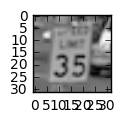

Image:  0  Sign name:  (33, b'Turn right ahead')


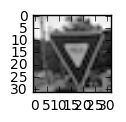

Image:  1  Sign name:  (13, b'Yield')


Image:  2  Sign name:  (23, b'Slippery road')


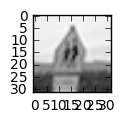

Image:  3  Sign name:  (11, b'Right-of-way at the next intersection')


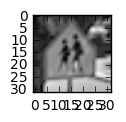

Image:  4  Sign name:  (6, b'End of speed limit (80km/h)')


In [18]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    softmax = tf.nn.softmax(logits)
    output = sess.run(softmax, feed_dict={x: X_new_images[0:5], dropout_prob: 1.0})

    i = 0
    for pred in output:
        image = X_new_images[i].squeeze()
        plt.figure(figsize=(1,1))
        plt.imshow(image, cmap="gray")
        plt.show()
        print("Image: ", i, " Sign name: ", sign_names[np.argmax(pred)])
        i += 1
        
    plt.close()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
My model did not perform as well on the additional captured images as compared to the test data set. It only predicted 1 out of 5 signs accurately.  

In [19]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    softmax = tf.nn.softmax(logits)
    top_five = tf.nn.top_k(softmax, k=5, sorted=True, name=None)
    print(sess.run(top_five, feed_dict={x: X_new_images[0:5], dropout_prob: 1.0}))

TopKV2(values=array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.99888521,  0.00111475,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ]], dtype=float32), indices=array([[33,  0,  1,  2,  3],
       [13,  0,  1,  2,  3],
       [23,  0,  1,  2,  3],
       [11, 28,  0,  1,  2],
       [ 6,  0,  1,  2,  3]], dtype=int32))


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

The probabilities show that the model is very confident (with probability > 0.9) with all the five candidate images even though only one of them is accurate. Why?

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.